In [53]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.image as mpimg
import cv2
from unified_planning.shortcuts import *

In [54]:

initial_img = 'legoscatter.png'
im = cv2.imread(initial_img)

In [55]:
#Claude Output
C_robot = [0,0]
C_P1 = [-6,8]
C_P2 = [-8,2]
C_P3 = [-2,4]
C_P4 = [4,6]
C_R1 = [6,0]
C_R2 = [-4,-7]
C_R3 = [7,-8]
C_G1 = [2,2]
C_G2 = [0,-4]


claude_x_points = [C_P1[0],C_P2[0],C_P3[0],C_P4[0],C_R1[0],C_R2[0],C_R3[0],C_G1[0],C_G2[0]]
claude_y_points = [C_P1[1],C_P2[1],C_P3[1],C_P4[1],C_R1[1],C_R2[1],C_R3[1],C_G1[1],C_G2[1]]

In [56]:
#Gemini Output
robot = [0,0]
P1 = [-3.33,8.75]
P2 = [6.66,7.5]
P3 = [-6.66,1.25]
P4 = [-3.33,3.75]
R1 = [8.33,-1.25]
R2 = [-8.33,-7.5]
R3 = [6.66,-8.75]
G1 = [1.66,3.75]
G2 = [0,-2.5]

gem_x_points = [P1[0],P2[0],P3[0],P4[0],R1[0],R2[0],R3[0],G1[0],G2[0]]
gem_y_points = [P1[1],P2[1],P3[1],P4[1],R1[1],R2[1],R3[1],G1[1],G2[1]]

In [57]:
#GPT Output

robot = [0,0]
P1 = [-5.29,6.26]
P2 = [-2.25,1.89]
P3 = [-5.88,-2.94]
# P4 = [5,-3.66]
R1 = [6.08,-2.74]
R2 = [-5.88,-8.04]
R3 = [5.29,1.86]
G1 = [0.39,4.12]
G2 = [-0.2,-4.9]

gpt_x_points = [P1[0],P2[0],P3[0],P4[0],R1[0],R2[0],R3[0],G1[0],G2[0]]
gpt_y_points = [P1[1],P2[1],P3[1],P4[1],R1[1],R2[1],R3[1],G1[1],G2[1]]

(4032, 3024, 3)


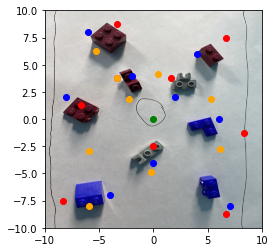

In [58]:
fig, ax = plt.subplots()

print(im.shape)
ax.imshow(im, extent=[-10, 10, -10, 10],aspect='equal')
ax.plot(0,0,'o',color='green')
ax.plot(gem_x_points, gem_y_points, 'o', color='red')
ax.plot(claude_x_points, claude_y_points, 'o', color='blue')
ax.plot(gpt_x_points, gpt_y_points, 'o', color='orange')
plt.show()
# plt.plot(x_points, y_points, 'o')W

In [59]:
# Grid boxes
# Continuing with claude!

points = [C_robot,C_P1,C_P2,C_P3,C_P4,C_R1,C_R2,C_R3,C_G1,C_G2]


def normaliser(x,oldmin,oldmax,newmin,newmax):
    normalised = ((x - oldmin) / (oldmax - oldmin)) * (newmax - newmin) + newmin
    return normalised

final_locations = []
for point in points:
    x_norm = round(normaliser(point[0],-10,10,0,20))
    y_norm = round(normaliser(point[1],-10,10,0,20))
    final_locations.append([x_norm,y_norm])

# normalized_value = ((x - old_min) / (old_max - old_min)) * (new_max - new_min) + new_min


In [60]:
#Unified Planning Object Locations

Location = UserType('Location')
Bricks = UserType('Bricks')
brick_at = unified_planning.model.Fluent('brick_at', BoolType(), l=Location)



In [61]:
#Create Grid Squares
locs = []
for y in range(20):
    for x in range(20):
        loc = f'loc-{x},{y}'
        locs.append(loc)
locations = [unified_planning.model.Object(l,Location) for l in locs]


In [62]:
#Create Brick Objects

seperate_bricks = ['P1','P2','P3','P4','R1','R2','R3','G1','G2']

bricks = [unified_planning.model.Object(b,Bricks) for b in seperate_bricks]




In [63]:

brick_at = unified_planning.model.Fluent('brick_at', BoolType(), brick = Bricks, loc = Location)
on = unified_planning.model.Fluent('on', BoolType(), base_brick = Bricks, stack_brick = Bricks)
left = unified_planning.model.Fluent('left', BoolType(), left_brick = Bricks, right_brick = Bricks)
behind = unified_planning.model.Fluent('behind', BoolType(), behind_brick = Bricks, forward_brick = Bricks)
touching = unified_planning.model.Fluent('touching', BoolType(), brick_one = Bricks, brick_two = Bricks)
clear = unified_planning.model.Fluent('clear',BoolType(), brick = Bricks)
problem = unified_planning.model.Problem('LegoScatter')



In [64]:
problem.add_fluent(brick_at, default_initial_value=False)
problem.add_fluent(on, default_initial_value=False)
problem.add_fluent(left, default_initial_value=False)
problem.add_fluent(behind, default_initial_value=False)
problem.add_fluent(touching, default_initial_value=False)
problem.add_fluent(clear, default_initial_value=False)

bool clear[brick=Bricks]

In [65]:
move = unified_planning.model.InstantaneousAction('move',brick = Bricks, l_from=Location, l_to=Location)
curr_brick = move.parameter('brick')
l_from = move.parameter('l_from')
l_to = move.parameter('l_to')
move.add_precondition(brick_at(curr_brick, l_from))
move.add_precondition(clear(curr_brick))
# move.add_precondition(robot_at(l_from))
move.add_effect(brick_at(curr_brick, l_from), False)
move.add_effect(brick_at(curr_brick, l_to), True)

In [66]:
move_on = unified_planning.model.InstantaneousAction('move_on',base_brick = Bricks, stack_brick = Bricks, l_curr=Location)
base_brick = move_on.parameter('base_brick')
l_curr = move_on.parameter('l_curr')
stack_brick = move_on.parameter('stack_brick')
move_on.add_precondition(brick_at(base_brick, l_curr))
move_on.add_precondition(brick_at(stack_brick, l_curr))
move.add_precondition(clear(base_brick))
move_on.add_effect(on(stack_brick,base_brick ), True)
move_on.add_effect(touching(base_brick,stack_brick), True)
move.add_effect(clear(stack_brick),False)


In [67]:
move_off = unified_planning.model.InstantaneousAction('move_off',base_brick = Bricks, stack_brick = Bricks, l_curr=Location)
base_brick = move_off.parameter('base_brick')
l_curr = move_off.parameter('l_curr')
stack_brick = move_off.parameter('stack_brick')
move_off.add_precondition(brick_at(base_brick, l_curr))
move_off.add_precondition(brick_at(stack_brick, l_curr))
move_off.add_precondition(on(stack_brick,base_brick))
move_on.add_precondition(touching(base_brick,stack_brick))
move.add_precondition(clear(stack_brick))
move_off.add_effect(on(stack_brick,base_brick ), False)
move_off.add_effect(touching(base_brick,stack_brick), False)
move_off.add_effect(clear(base_brick),True)


In [68]:
#Left
move_left = unified_planning.model.InstantaneousAction('move_left',left_brick = Bricks, right_brick = Bricks, l_curr=Location)
left_brick = move_left.parameter('left_brick')
l_curr = move_left.parameter('l_curr')
right_brick = move_left.parameter('right_brick')
move_left.add_precondition(brick_at(left_brick, l_curr))
move_left.add_precondition(brick_at(right_brick, l_curr))
move_left.add_precondition(clear(left_brick))
move_left.add_effect(left(left_brick,right_brick ), True)


In [69]:
#Behind
move_behind = unified_planning.model.InstantaneousAction('move_behind',behind_brick = Bricks, front_brick = Bricks, l_curr=Location)
behind_brick = move_behind.parameter('behind_brick')
l_curr = move_behind.parameter('l_curr')
front_brick = move_behind.parameter('front_brick')
move_behind.add_precondition(brick_at(behind_brick, l_curr))
move_behind.add_precondition(brick_at(front_brick, l_curr))
move_left.add_precondition(clear(behind_brick))
move_behind.add_effect(behind(behind_brick,front_brick ), True)

In [70]:
#Touching
brick_touching = unified_planning.model.InstantaneousAction('touching',brick_one = Bricks, brick_two = Bricks, l_curr=Location)
brick_one = brick_touching.parameter('brick_one')
l_curr = brick_touching.parameter('l_curr')
brick_two = brick_touching.parameter('brick_two')
brick_touching.add_precondition(brick_at(brick_one, l_curr))
brick_touching.add_precondition(brick_at(brick_two, l_curr))
brick_touching.add_precondition(Or
                                (left(brick_one,brick_two),
                                behind(brick_one,brick_two))
                                )
brick_touching.add_effect(touching(brick_one,brick_two), True)


In [71]:
#Not Touching

not_touching = unified_planning.model.InstantaneousAction('touching',brick_one = Bricks, brick_two = Bricks, l_curr=Location)
brick_one = brick_touching.parameter('brick_one')
l_curr = brick_touching.parameter('l_curr')
brick_two = brick_touching.parameter('brick_two')
brick_touching.add_precondition(brick_at(brick_one, l_curr))
brick_touching.add_precondition(brick_at(brick_two, l_curr))
brick_touching.add_precondition(Or
                                (touching(brick_one,brick_two),
                                touching(brick_two,brick_one))
                                )
brick_touching.add_effect(touching(brick_one,brick_two), False)
brick_touching.add_effect(touching(brick_two,brick_one), False)


In [72]:
#Initialise Locations
# print(final_locations[1:])
# print(bricks)
for i in range(len(bricks)):
    loc = Object(f'loc-{final_locations[i+1][0]},{final_locations[i+1][1]}',Location)
    # print(loc)
    problem.set_initial_value(brick_at(bricks[i],loc),True)
    problem.set_initial_value(clear(bricks[i]), True)

In [73]:
print(problem)

problem name = LegoScatter

types = [Bricks, Location]

fluents = [
  bool brick_at[brick=Bricks, loc=Location]
  bool on[base_brick=Bricks, stack_brick=Bricks]
  bool left[left_brick=Bricks, right_brick=Bricks]
  bool behind[behind_brick=Bricks, forward_brick=Bricks]
  bool touching[brick_one=Bricks, brick_two=Bricks]
  bool clear[brick=Bricks]
]

actions = [
]

objects = [
  Bricks: []
  Location: []
]

initial fluents default = [
  bool brick_at[brick=Bricks, loc=Location] := false
  bool on[base_brick=Bricks, stack_brick=Bricks] := false
  bool left[left_brick=Bricks, right_brick=Bricks] := false
  bool behind[behind_brick=Bricks, forward_brick=Bricks] := false
  bool touching[brick_one=Bricks, brick_two=Bricks] := false
  bool clear[brick=Bricks] := false
]

initial values = [
  brick_at(P1, loc-4,18) := true
  clear(P1) := true
  brick_at(P2, loc-2,12) := true
  clear(P2) := true
  brick_at(P3, loc-8,14) := true
  clear(P3) := true
  brick_at(P4, loc-14,16) := true
  clear(P4) :=

In [74]:
##Goal Locations

problem.add_goal(on(Object("P1",Bricks),Object("P2",Bricks)))
problem.add_goal(on(Object("P2",Bricks),Object("P3",Bricks)))
problem.add_goal(on(Object("P3",Bricks),Object("P4",Bricks)))
problem.add_goal(on(Object("R1",Bricks),Object("R2",Bricks)))
problem.add_goal(on(Object("R2",Bricks),Object("R3",Bricks)))
problem.add_goal(on(Object("G1",Bricks),Object("G2",Bricks)))

In [75]:
print(problem)

problem name = LegoScatter

types = [Bricks, Location]

fluents = [
  bool brick_at[brick=Bricks, loc=Location]
  bool on[base_brick=Bricks, stack_brick=Bricks]
  bool left[left_brick=Bricks, right_brick=Bricks]
  bool behind[behind_brick=Bricks, forward_brick=Bricks]
  bool touching[brick_one=Bricks, brick_two=Bricks]
  bool clear[brick=Bricks]
]

actions = [
]

objects = [
  Bricks: []
  Location: []
]

initial fluents default = [
  bool brick_at[brick=Bricks, loc=Location] := false
  bool on[base_brick=Bricks, stack_brick=Bricks] := false
  bool left[left_brick=Bricks, right_brick=Bricks] := false
  bool behind[behind_brick=Bricks, forward_brick=Bricks] := false
  bool touching[brick_one=Bricks, brick_two=Bricks] := false
  bool clear[brick=Bricks] := false
]

initial values = [
  brick_at(P1, loc-4,18) := true
  clear(P1) := true
  brick_at(P2, loc-2,12) := true
  clear(P2) := true
  brick_at(P3, loc-8,14) := true
  clear(P3) := true
  brick_at(P4, loc-14,16) := true
  clear(P4) :=

In [76]:
with OneshotPlanner(problem_kind=problem.kind) as planner:
    result = planner.solve(problem)
    print("%s returned: %s" % (planner.name, result.plan))

UPNoSuitableEngineAvailableException: No available OperationMode.ONESHOT_PLANNER engine